<img src="https://imgur.com/gallery/07IZW" style="float: left; margin: 20px; height: 55px"> 

# Rage Against the Machine:
## Ethics, Privacy & Artificial Intelligence

AI presents three major areas of ethical concern for society: privacy and surveillance, bias and discrimination, and perhaps the deepest, most difficult philosophical question of the era, the role of human judgment and it’s relative importance.

I hypothesize that the rate of advancement in Artificial Intelligence and Machine Learning far outpaces humans' ability to reasonably adapt to the seemingly endless ethical dilemmas presented by evolving technology. Furthermore, I believe that without a continuous and deliberate consideration of the morality of AI, we may find ourselves in a society where human rights are significantly deprioritized in the name of innovation.

Using Machine Learning, I will demonstrate how powerful Artificial Intelligence can be, and how that level of “intelligence” could be detrimental.

----

# Import Libraries
----

In [3]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [190]:
df = pd.read_csv('./reddit_full.csv')

# Web Scraping and Creating DataFrame

The webscraping code remains, but is commented out, to avoid spilling further Data into our Dataframe. Using the code below, we pulled in 2000 post, 1000 from each subreddit. Most of the post in our subreddits didn't include body text, so that column was removed as well. The meat of our data is the actual post titles themselves, and that is our lone X variable.

----

In [189]:
# url = 'https://api.pushshift.io/reddit/search/submission'

# params = {
#     'subreddit': 'samsung',
#     'size': 100,
#     'before': 1615973288
# }

# res = requests.get(url, params)

# res.status_code

In [157]:
# data = res.json()

In [183]:
# posts = data['data']

In [184]:
# posts[0]['created_utc']

In [185]:
# for_merge = pd.DataFrame(posts)

In [186]:
# reddit_df = pd.concat([reddit_df, for_merge])

In [187]:
# reddit_df.shape

In [188]:
# df = reddit_df[['subreddit', 'selftext', 'title']]

In [172]:
# df.reset_index(drop=True, inplace = True)

# Data Cleaning

Nothing to do here except isolate our X variable, and map our y to "1" and "0". Because of the rules within the subreddits I chose, empty posts and post without a title are not allowed, so we have no Nulls. We will also be vectorizing the Text data in during our modeling, so there may be a need to clean more at a later point in the project.

----

In [181]:
# df['subreddit'] = df['subreddit'].map({0: 0, 1: 1, 'samsung': 2, 'iphone': 3})

In [182]:
# df.drop(columns='selftext', inplace = True)

In [180]:
# df['subreddit'].value_counts()

0    1000
2    1000
1    1000
3    1000
Name: subreddit, dtype: int64

# EDA using KMeans and PCA to Visualize Clusters and text relationships

It could be beneficial to check out some of the relationships between certain words. These two subreddits have tremendous amounts of overlap, where the sometimes the only differences are in sentiment. Let's take a precurser look at how the machine will handle the similarities.

----

In [280]:
from sklearn.cluster import KMeans
X = df['title']

tv = TfidfVectorizer(max_features=5000, ngram_range=(1,1), stop_words='english')
X = tv.fit_transform(X)



NUMBER_OF_CLUSTERS = 4
km = KMeans(
    n_clusters=NUMBER_OF_CLUSTERS, 
    init='k-means++', 
    max_iter=500)
km.fit(X)

KMeans(max_iter=500, n_clusters=4)

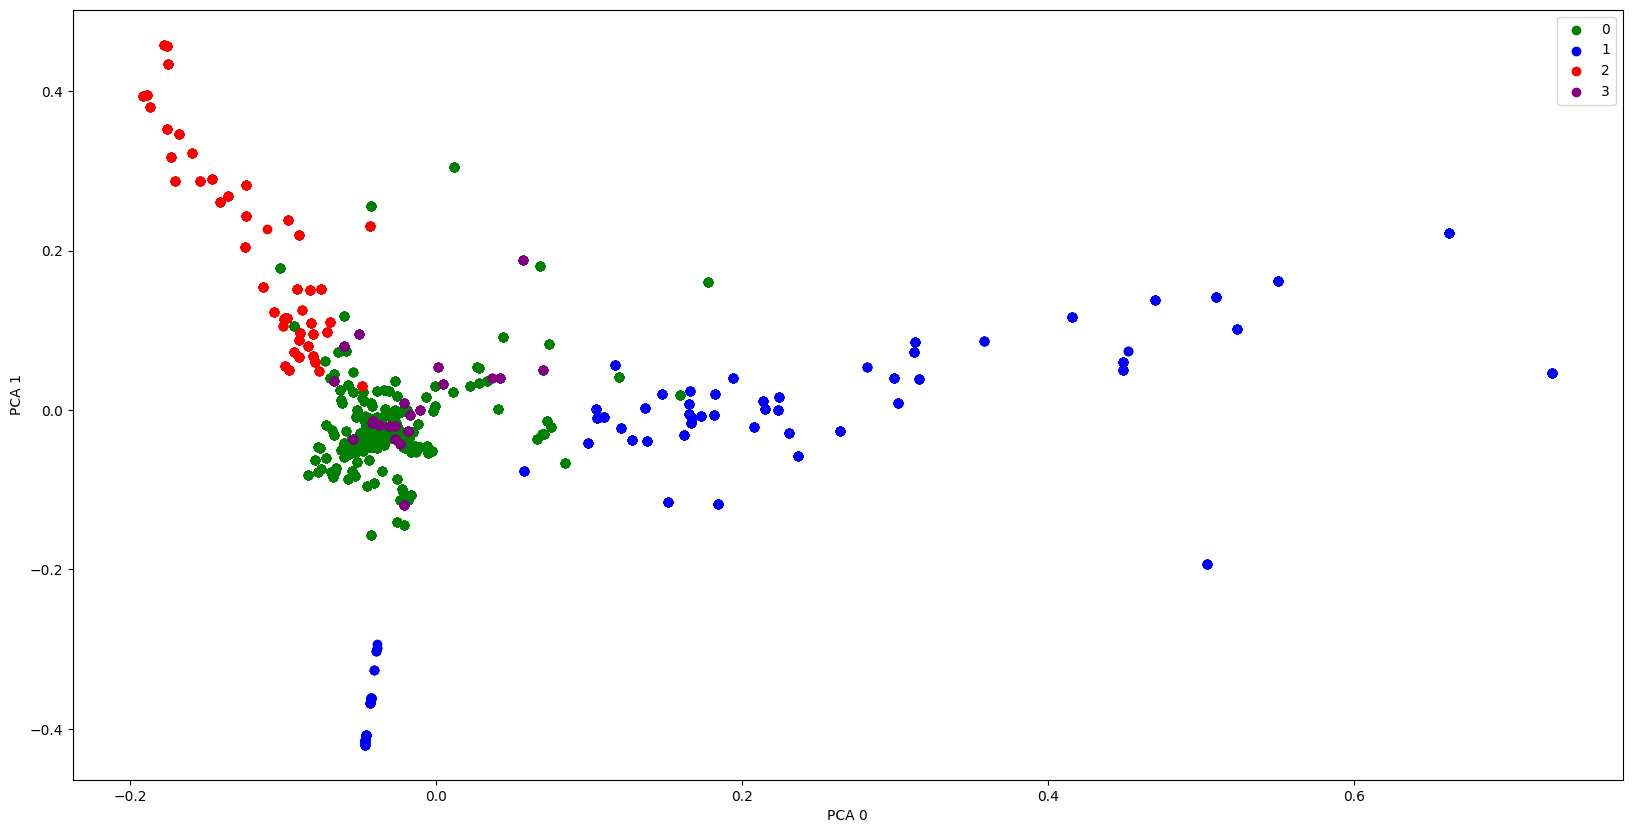

<Figure size 640x480 with 0 Axes>

In [290]:
from sklearn.decomposition import PCA

clusters = km.predict(X)
 
pca = PCA(n_components=6)
two_dim = pca.fit_transform(X.todense())

scatter_x = two_dim[:, 0]
scatter_y = two_dim[:, 1] 

# Credit to Saftophobia over at stackexchange for the help in making this awesome plot!

plt.style.use('default')

fig, ax = plt.subplots()
fig.set_size_inches(20,10)

cmap = {0: 'green', 1: 'blue', 2: 'red', 3: 'purple'}


for group in np.unique(clusters):
    ix = np.where(clusters == group)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cmap[group], label=group)

ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.show();

plt.savefig('./clustermap.png', dpi = 500)

The Scatter plot above is a visualization of our Kmeans clustering, showing the relationships our Machine Learning model found within our Data.

In [283]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

terms = tv.get_feature_names()
for i in range(4):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: apple android app help phone google s21 play battery event
Cluster 1: iphone 12 new firmware pda sm pro 11 apple sim
Cluster 2: samsung galaxy note a52 series 5g year unpacked chip 2021
Cluster 3: m1 macbook ipad air vs pro 13 mac apple intel


These are the first 10 words within each of the 4 clusters.

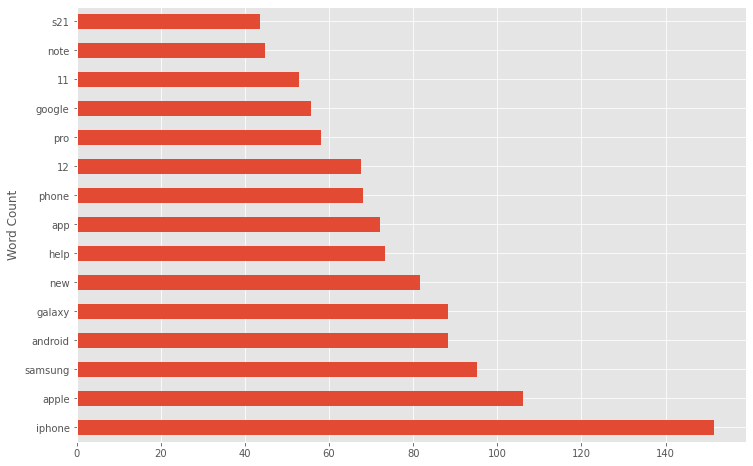

In [287]:
X_train_df = pd.DataFrame(X.todense(), 
                          columns=tv.get_feature_names())


X_train_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', figsize = (12,8), ylabel = 'Word Count');

plt.savefig('./wordcount.png', dpi=500)

The Bar plot above shows the 15 most common words within our Data Frame. 

# Preprocessing and Modeling

We'll be running our Data through a number of different pipelines to determine the best parameters and Estimators for our model. We'll Gridsearch through the Pipes, fitting a few thousand models in the process. 

----

In [201]:
X = df['title']

y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   stratify = y,
                                                   test_size = .33,
                                                   random_state=808)

#### Null Model

In [202]:
y.mean()

1.5

# Pipelines

### TfidfVectorizer Pipe

In [293]:
pipe_lr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

pipe_lr_params = {
    
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)],
    'lr__C': [0.001,0.01,1]
        
}
    

# --------------------------------

pipe_mb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_mb_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [1,5,10]
}

# --------------------------------

pipe_rf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_rf_params = {
    
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5],
}
# --------------------------------

pipe_svc = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
])

pipe_svc_params = {
    
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)],
    'svc__C':np.arange(1, 5, 20),
    'svc__kernel':['linear', 'rbf', 'polynomial','sigmoid'],
    'svc__degree':[1, 2, 3, 4]
}

# --------------------------------

pipe_xgb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('xgb', XGBClassifier(use_label_encoder=False, objective='binary:logistic', learning_rate = 0.02, verbosity = 0))
])

pipe_xgb_params = {
    
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)],
    
}

# --------------------------------
gs_lr_tvec = GridSearchCV(pipe_lr, pipe_lr_params, cv=3, verbose=1)
gs_mb_tvec = GridSearchCV(pipe_mb, pipe_mb_params, cv=3, verbose=1)
gs_rf_tvec = GridSearchCV(pipe_rf, pipe_rf_params, cv=3, verbose=1)
gs_svc_tvec = GridSearchCV(pipe_svc, pipe_svc_params, cv=3, verbose=1)
gs_xgb_tvec = GridSearchCV(pipe_xgb, pipe_xgb_params, cv =3, verbose=1)

### CountVectorizer Pipe

In [204]:
pipe_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe_lr_params = {
    
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__C': [0.001,0.01,1]
        
}
    

# --------------------------------

pipe_mb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_mb_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [1,5,10]
}

# --------------------------------

pipe_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_rf_params = {
    
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [100, 150, 200],
}
# --------------------------------

pipe_svc = Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', SVC())
])

pipe_svc_params = {
    
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'svc__C':np.arange(1, 5, 20),

}

# --------------------------------

pipe_xgb = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb', XGBClassifier(use_label_encoder=False, objective='binary:logistic', learning_rate = 0.02, verbosity = 0))
])

pipe_xgb_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    
}

# --------------------------------

gs_lr_cvec = GridSearchCV(pipe_lr, pipe_lr_params, cv=3,verbose=1)
gs_mb_cvec = GridSearchCV(pipe_mb, pipe_mb_params, cv=3, verbose=1)
gs_rf_cvec = GridSearchCV(pipe_rf, pipe_rf_params, cv=3, verbose=1)
gs_svc_cvec = GridSearchCV(pipe_svc, pipe_svc_params, cv=3, verbose=1)
gs_xgb_cvec = GridSearchCV(pipe_xgb, pipe_xgb_params, cv =3, verbose=1)


In [292]:
gs_lr_tvec.fit(X_train, y_train)
gs_mb_tvec.fit(X_train, y_train)
gs_rf_tvec.fit(X_train, y_train)
gs_svc_tvec.fit(X_train, y_train)
gs_xgb_tvec.fit(X_train, y_train)

# --------------------------------

gs_lr_cvec.fit(X_train, y_train)
gs_mb_cvec.fit(X_train, y_train)
gs_rf_cvec.fit(X_train, y_train)
gs_svc_cvec.fit(X_train, y_train)
gs_xgb_cvec.fit(X_train, y_train)

### GridSearch Results

In [206]:
tvec_df = pd.DataFrame({'tvec Logisitc Regression scores': [gs_lr_tvec.score(X_train,y_train),gs_lr_tvec.score(X_test,y_test)],
                        'tvec MultinomialNB scores': [gs_mb_tvec.score(X_train,y_train) ,gs_mb_tvec.score(X_test,y_test)],
                        'tvec Random Forest scores': [gs_rf_tvec.score(X_train,y_train), gs_rf_tvec.score(X_test,y_test)],
                        'tvec SVC scores': [gs_svc_tvec.score(X_train,y_train), gs_svc_tvec.score(X_test,y_test)],
                        'tvec XGBoost scores': [gs_xgb_tvec.score(X_train,y_train), gs_xgb_tvec.score(X_test,y_test)]},
                        index=['train', 'test']).T



cvec_df = pd.DataFrame({'cvec Logisitc Regression scores': [gs_lr_cvec.score(X_train,y_train),gs_lr_cvec.score(X_test,y_test)],
                        'cvec MultinomialNB scores': [gs_mb_cvec.score(X_train,y_train) ,gs_mb_cvec.score(X_test,y_test)],
                        'cvec Random Forest scores': [gs_rf_cvec.score(X_train,y_train), gs_rf_cvec.score(X_test,y_test)],
                        'cvec SVC scores': [gs_svc_cvec.score(X_train,y_train), gs_svc_cvec.score(X_test,y_test)],
                        'cvec XGBoost scores': [gs_xgb_cvec.score(X_train,y_train), gs_xgb_cvec.score(X_test,y_test)]},
                        index=['train', 'test']).T

gridsearch_df = pd.concat([cvec_df,tvec_df])

gridsearch_df

,train,test
cvec Logisitc Regression scores,0.985821,0.977273
cvec MultinomialNB scores,0.976866,0.967424
cvec Random Forest scores,0.986940,0.981061
cvec SVC scores,0.985821,0.976515
cvec XGBoost scores,0.847761,0.800758
tvec Logisitc Regression scores,0.986567,0.978788
tvec MultinomialNB scores,0.986567,0.978788
tvec Random Forest scores,0.986940,0.980303
tvec SVC scores,0.986940,0.980303
tvec XGBoost scores,0.869030,0.831818


The best scores are from our Random Forest Model using the CountVectorizer Transformer. 

In [207]:
bp_df = pd.DataFrame(gs_rf_cvec.best_params_,index=['Best Params','bp']).T.head(10)

bp_df.drop(columns = 'bp', inplace = True)

bp_df

,Best Params
cvec__max_df,0.95
cvec__max_features,4000.00
cvec__min_df,2.00
cvec__ngram_range,1.00
rf__n_estimators,150.00


# Random Forest Classification Model
----

In [294]:
X = df['title']

y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = .33,
                                                   random_state=808)

# --------------------------------

cvec = CountVectorizer(max_df = 0.95, max_features=4000, ngram_range=(1,1), stop_words='english')
X_train = cvec.fit_transform(X_train)
X_test = cvec.transform(X_test)

# --------------------------------

rf = RandomForestClassifier(n_estimators=150)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=150)

In [299]:
tn

array([317,   0,   0,   3])

In [309]:
# from sklearn.metrics import multilabel_confusion_matrix

train_acc = rf.score(X_train,y_train)

test_acc = rf.score(X_test,y_test)

preds = rf.predict(X_test)

# num_classes = 4

# y_categorial = np.eye(num_classes)[preds]

# # from categorial to lable indexing
# preds = y_categorial.argmax(1)

tn, fp, fn, tp = confusion_matrix(y_test, preds)

# --------------------------------

# accuracy = (tp +tn) / (tp+fp+fn+tn)

# precision = tp / (tp+fp)

# sensitivity = tp / (tp+fn)

# specificity = tn / (tn+fp)

# f1 = 2*(sensitivity*precision) / (sensitivity+precision) 

# --------------------------------

rf_scores = pd.DataFrame(classification_report(y_test, preds, output_dict=True, target_names = ['android', 'apple', 'iphone', 'samsung'])).T
rf_scores['Test Accuracy'] = test_acc
rf_scores['Train Accuracy'] = train_acc
# --------------------------------
rf_scores

,precision,recall,f1-score,support,Test Accuracy,Train Accuracy
android,0.943452,0.990625,0.966463,320.000000,0.980303,0.98694
apple,0.987692,0.993808,0.990741,323.000000,0.980303,0.98694
iphone,1.000000,0.988304,0.994118,342.000000,0.980303,0.98694
samsung,0.990654,0.949254,0.969512,335.000000,0.980303,0.98694
accuracy,0.980303,0.980303,0.980303,0.980303,0.980303,0.98694
macro avg,0.980450,0.980498,0.980208,1320.000000,0.980303,0.98694
weighted avg,0.980908,0.980303,0.980343,1320.000000,0.980303,0.98694


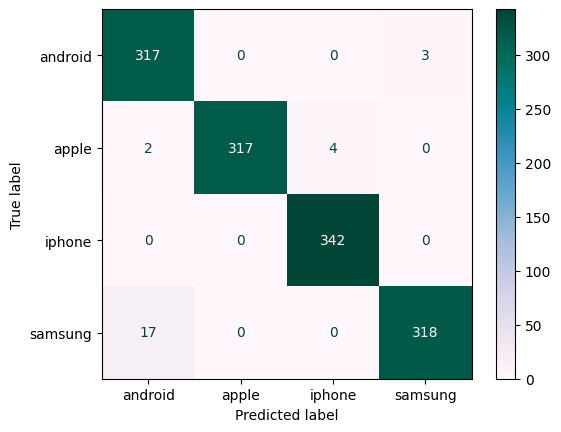

In [291]:
plot_confusion_matrix(rf, X_test, y_test, cmap='PuBuGn', values_format='d', display_labels=['android', 'apple', 'iphone', 'samsung']);

# plt.savefig('./confusionm.png', dpi=500)

# Conclusion
___

Our Model Performed exceptionally well. We were able to predict accurately 98% of the time. After numerous test and analysis, their seems to be no identifiable flaw in our model, and after testing it on multiple sources of unseen data, we can conclude that for the purposes set out in this project, that this model was succesful. 